Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


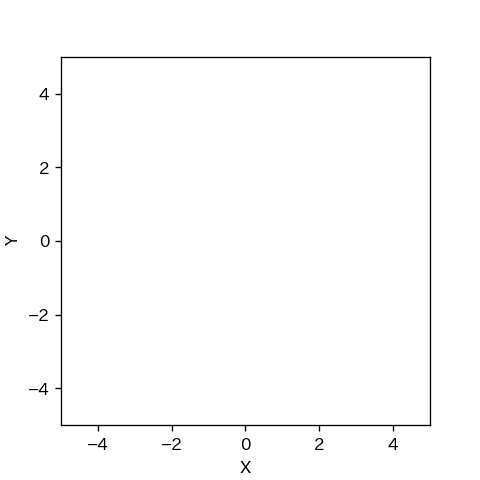

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m, phantom_prob=0.1),agent=a,color="red")
    world.append(r)
#, phantom_prob=0.1
    world.draw()
    return (r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


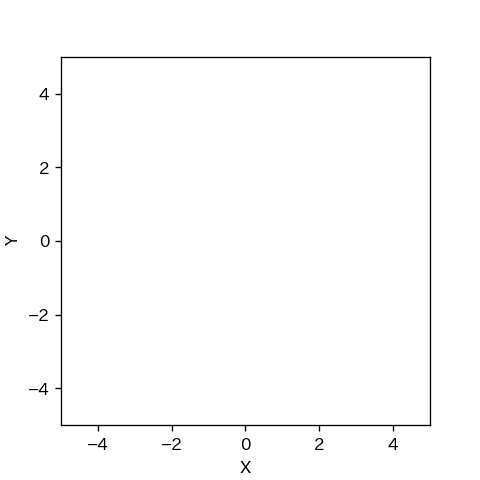

(array([ 2.77009224,  0.7350692 , -0.46650054]),
 array([ 2.12872742,  4.62151332, -1.49804441]))

In [4]:
trial_phantom_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[2.72008750419239]
0 真値: [-5.57835723 -0.26534742  5.2334232 ] 推定値: [-3.33005634 -1.04300052  5.55535166] 誤差: 2.3789916409143537
[2.041624426951471]
1 真値: [-4.44962351  2.39680466  5.17399275] 推定値: [-3.35575952  1.8370389   2.46155623] 誤差: 1.228770173006825
[1.751649041700135]
[6.266312439887406]
2 真値: [-1.90617812  1.37816501  7.00743107] 推定値: [-0.63418117  7.0572824  -0.40075272] 誤差: 5.81982393175242
[4.624888620114583]
3 真値: [-3.18134066 -2.63850884  7.97550579] 推定値: [-2.8890903  -2.63031205  7.99405292] 誤差: 0.2923652886533789
1
[4.556673222828909]
[4.473869712428025, 6.659979872779935]
[4.2335383862884, 4.484719243569298]
4 真値: [0.71540724 2.52060788 3.41187164] 推定値: [2.10408272 2.48824838 3.39288439] 誤差: 1.3890524599976994
[3.3944778492438012]
[3.1440882438102262, 5.062109973165863]
5 真値: [-4.03583488  2.26603563  6.56053186] 推定値: [-4.26396881  1.60945032  0.90729259] 誤差: 0.6950894613009748
2
[4.159196054677674]
6 真値: [ 0.94325622 -4.21451159  2.02791173] 推定値: [ 3.56873523 -2.7834

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[5.567906895471443]
[5.59810868088029, 1.5476385832522255]
[4.512398431904695]
20 真値: [ 0.87536085 -0.9726279   8.30514926] 推定値: [ 0.94106196 -1.13693658  8.2359152 ] 誤差: 0.17695755254976298
12
[1.8625543662169175]
21 真値: [-4.7440433   0.19262807  5.87557985] 推定値: [-2.6223019   0.09724059  6.93478266] 誤差: 2.123884501059167
[3.5561709227153724]
[5.057544512981021, 5.231807913156713]
[3.866758334198188, 4.919233050393855]
[5.123176502076825, 5.996549326516846]
22 真値: [-2.63699767 -1.80158667  5.46878807] 推定値: [-2.93204015 -2.36550055  5.634043  ] 誤差: 0.6364345393521034
13
23 真値: [ 3.4315285  -7.01269651  0.96350642] 推定値: [-4.65426092 -1.82591492  5.15676119] 誤差: 9.60638817634626
24 真値: [-4.80754296  2.37214075  8.7063518 ] 推定値: [-3.64799255  0.96859627  5.10610747] 誤差: 1.8205752593592648
[2.0338065645821826]
[5.073754809549549]
25 真値: [-0.3132383  -3.31302806  5.00459373] 推定値: [ 2.94868062 -3.75263785  4.66753634] 誤差: 3.29140879278807
[2.357190605215581]
26 真値: [ 2.63164108 -0.19083861  